In [144]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
import warnings
warnings.filterwarnings('ignore')
import ast
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score,recall_score,precision_score,roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [18]:
#fill nulls and take a subset of features
def clean(df):
    #very few nulls in the data set -- filling them with the column mean
    df.fillna(df.mean(),inplace=True)
    #subset of data features based on EDA and correlation analysis
    data1=df[['TEETHLOST_CrudePrev','STROKE_CrudePrev','PHLTH_CrudePrev','OBESITY_CrudePrev','MHLTH_CrudePrev','LPA_CrudePrev','KIDNEY_CrudePrev','DENTAL_CrudePrev','DIABETES_CrudePrev','CSMOKING_CrudePrev','COREW_CrudePrev','COPD_CrudePrev','CHOLSCREEN_CrudePrev','CASTHMA_CrudePrev','ACCESS2_CrudePrev','PovertyRate','TractSNAP','comp_healthy','comp_unhealthy','comp_grocery','comp_ff','Population2010','PCTGQTRS','HUNVFlag']]
    data1['TractLOWI']=df['TractLOWI']/df['Population2010']
    data1['TractKids']=df['TractKids']/df['Population2010']
    data1['TractSeniors']=df['TractSeniors']/df['Population2010']
    data1['TractWhite']=df['TractWhite']/df['Population2010']
    data1['TractBlack']=df['TractBlack']/df['Population2010']
    data1['TractAsian']=df['TractAsian']/df['Population2010']
    data1['TractNHOPI']=df['TractNHOPI']/df['Population2010']
    data1['TractAIAN']=df['TractAIAN']/df['Population2010']
    data1['TractOMultir']=df['TractOMultir']/df['Population2010']
    data1['TractHispanic']=df['TractHispanic']/df['Population2010']
    data1['TractHUNV']=df['TractHUNV']/df['Population2010']
    data1['TractSNAP']=df['TractSNAP']/df['Population2010']
    return data1

In [127]:
#prepping data for modeling
def prep_data():

    #food desert data + poverty rates + SNAP counts
    food_desert = pd.ExcelFile('data/food_desert_data.xlsx')

    #just want  data, other sheets in the excel workbook are a readME and variable description
    desert_data = food_desert.parse(2)
    #set index to prepare for merging data sets
    desert_data['CensusTract']=desert_data['CensusTract'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    desert_data.set_index('CensusTract', inplace=True)


    #behavior and health data 
    behav = pd.read_csv('data/population_health.csv',)
    #setting index to the same feature as desert_data
    behav['TractFIPS']=behav['TractFIPS'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    behav.set_index('TractFIPS', inplace=True)

    #merge the data sets tp create our large dataset
    merge1 = behav.merge(desert_data, how='inner', left_index=True, right_index=True)    

    #ready for splitting data
    #target food desert classification
    y=merge1.pop('LILATracts_halfAnd10')
    #feature matrix
    X=merge1
    X['county'] = [i[:5] for i in X.index]
    
    print("Preparing Healthy DF")
    healthy_clean=pd.read_csv('data/twitter_mongo/healthy_final.csv',index_col=0)
    #healthy_clean['census']=healthy_clean['census'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    #healthy_clean['county'] = healthy_clean['census'].apply(lambda x: x[:5])
    #healthy_clean['sentiment']=healthy_clean['sentiment'].apply(ast.literal_eval)
    #healthy_clean['comp_healthy']=healthy_clean['sentiment'].apply(lambda x: x['compound'])
    healthy_clean['comp_healthy']=healthy_clean['comp']
    county_sent_healthy = healthy_clean.groupby('county').mean()['comp_healthy']
    county_sent_healthy = county_sent_healthy.reset_index()
    
    print("Preparing Unealthy DF")
    unhealthy_clean=pd.read_csv('data/twitter_mongo/unhealthy_final.csv',index_col=0)
    #unhealthy_clean['census']=unhealthy_clean['census'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    #unhealthy_clean.dropna(axis=0, inplace=True)
    #unhealthy_clean.census=unhealthy_clean.census.apply(float)
    #unhealthy_clean.dropna(axis=0, inplace=True)
    #unhealthy_clean.census=unhealthy_clean.census.apply(int)
    #unhealthy_clean['census']=unhealthy_clean['census'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    #unhealthy_clean['county'] = unhealthy_clean['census'].apply(lambda x: x[:5])
    #unhealthy_clean['sentiment']=unhealthy_clean['sentiment'].apply(ast.literal_eval)
    #unhealthy_clean['comp_unhealthy']=unhealthy_clean['sentiment'].apply(lambda x: x['compound'])
    unhealthy_clean['comp_unhealthy']=unhealthy_clean['comp']
    county_sent_unhealthy = unhealthy_clean.groupby('county').mean()['comp_unhealthy']
    county_sent_unhealthy = county_sent_unhealthy.reset_index()
    
    print("Preparing Grocery DF")
    grocery_stores_clean=pd.read_csv('data/twitter_mongo/grocery_stores_final.csv',index_col=0)
    #grocery_stores_clean['census']=grocery_stores_clean['census'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    #grocery_stores_clean['county'] = grocery_stores_clean['census'].apply(lambda x: x[:5])
    #grocery_stores_clean['sentiment']=grocery_stores_clean['sentiment'].apply(ast.literal_eval)
    #grocery_stores_clean['comp_grocery']=grocery_stores_clean['sentiment'].apply(lambda x: x['compound'])
    grocery_stores_clean['comp_grocery']=grocery_stores_clean['comp']
    county_sent_grocery = grocery_stores_clean.groupby('county').mean()['comp_grocery']
    county_sent_grocery = county_sent_grocery.reset_index()
 
    print("Preparing FF DF")
    ff_stores_clean=pd.read_csv('data/twitter_mongo/ff_stores_final.csv',index_col=0)
    #ff_stores_clean['census']=ff_stores_clean['census'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    #ff_stores_clean['county'] = ff_stores_clean['census'].apply(lambda x: x[:5])
    #ff_stores_clean['sentiment']=ff_stores_clean['sentiment'].apply(ast.literal_eval)
    #ff_stores_clean['comp_ff']=ff_stores_clean['sentiment'].apply(lambda x: x['compound'])
    ff_stores_clean['comp_ff']=ff_stores_clean['comp']
    county_sent_ff = ff_stores_clean.groupby('county').mean()['comp_ff']
    county_sent_ff = county_sent_ff.reset_index()
    
    print("Merging county sentiment")
    X1 = pd.merge(X,county_sent_healthy,how='left',left_on='county', right_on='county')
    X2 = pd.merge(X1,county_sent_unhealthy,how='left',left_on='county', right_on='county')
    X3 = pd.merge(X2,county_sent_grocery,how='left',left_on='county', right_on='county')
    X4 = pd.merge(X3,county_sent_ff,how='left',left_on='county', right_on='county')


    X4.fillna(-1,inplace=True)

    #train test split
    X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.20, random_state=42)

    #perform cleaning on each dataset independently to prep for model fit and predict
    print("Cleaning train and test DF")
    df_train = clean(X_train)
    df_test = clean(X_test)

    #return training and testing sets
    return df_train,y_train,df_test,y_test

In [20]:
df_train,y_train,df_test,y_test = prep_data()

Preparing Healthy DF
Preparing Unealthy DF
Preparing Grocery DF
Preparing FF DF
Merging county sentiment
Cleaning train and test DF


In [28]:
#SVM
model = LinearSVC(penalty='l2',loss='hinge')
print("SVM")
print()

print("TRAIN on SVM")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

model.fit(df_train,y_train)
y_pred = model.predict(df_test)

print()
print("TEST on SVM")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

SVM


TEST on SVM
ROC_AUC score:  0.5888952503508426
Accuracy score:  0.4763830178276052
f1 score:  0.5754731038593354
recall score:  0.9882292732855681
precision score:  0.4059281059491276


In [146]:
#Logistic Reg
model = LogisticRegression(penalty='l1')
print("LogReg")
print()

print("TRAIN on LogReg")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

model.fit(df_train,y_train)
y_pred = model.predict(df_test)

print()
print("TEST on LogReg")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

LogReg

TRAIN on LogReg
ROC_AUC score:  0.9060467027812752
Accuracy score:  0.8205669412406589
f1 score:  0.7389697010854135

TEST on LogReg
ROC_AUC score:  0.7937386385284251
Accuracy score:  0.8189671016357287
f1 score:  0.7364195879047365
recall score:  0.7041965199590583
precision score:  0.7717330342120022


In [29]:
#GB
model = GradientBoostingClassifier()
print("GRADIENT BOOSTING")
print()

print("TRAIN on GB")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

model.fit(df_train,y_train)
y_pred = model.predict(df_test)

print()
print("TEST on GB")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

GRADIENT BOOSTING

TRAIN on GB
ROC_AUC score:  0.9520615656566216
Accuracy score:  0.8826449030249591
f1 score:  0.8355648452275559

TEST on GB
ROC_AUC score:  0.8719277245296833
Accuracy score:  0.8845800404337438
f1 score:  0.8373056994818652
recall score:  0.827021494370522
precision score:  0.8478488982161595


In [31]:
#RF model
model=RandomForestClassifier()

#new RF params
print("RANDOM FOREST")
print()

#train stats
print("TRAIN on RF")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

#predict and get test stats
model.fit(df_train,y_train)
y_pred = model.predict(df_test)

print()
print("TEST on RF")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

RANDOM FOREST

TRAIN on RF
ROC_AUC score:  0.9377089025841098
Accuracy score:  0.8640356422548343
f1 score:  0.808193083369607

TEST on RF
ROC_AUC score:  0.8452451259965733
Accuracy score:  0.8663848557250505
f1 score:  0.8054589242708055
recall score:  0.77021494370522
precision score:  0.8440830061693775


In [189]:
def permutation_importance(model, X_test, y_test, scorer=f1_score):
    ''' Calculates permutation feature importance for a fitted model
    
    Parameters
    ----------
    model: anything with a predict() method
    X_test, y_test: numpy arrays of data
        unseen by model
    scorer: function. Should be a "higher is better" scoring function,
        meaning that if you want to use an error metric, you should
        multiply it by -1 first.
        ex: >> neg_mse = lambda y1, y2: -mean_squared_error(y1, y2)
            >> permutation_importance(mod, X, y, scorer=neg_mse)
    
    Returns
    -------
    feat_importances: numpy array of permutation importance
        for each feature
    
    '''
    
    feat_importances = np.zeros(X_test.shape[1])
    test_score = scorer(model.predict(X_test), y_test)
    for i in range(X_test.shape[1]):
        X_test_shuffled = shuffle_column(X_test, i)
        test_score_permuted = scorer(y_test, model.predict(X_test_shuffled))
        feat_importances[i] = test_score - test_score_permuted
    return feat_importances

def shuffle_column(X, feature_index):
    ''' 
    Parameters
    ----------
    X: numpy array
    feature_index: int
    
    Returns
    -------
    X_new: numpy array
    
    Returns a new array identical to X but
    with all the values in column feature_index
    shuffled
    '''   
    
    X_new = X.copy()
    np.random.shuffle(X_new[:,feature_index])
    return X_new

## Plot of feature importances
def plot_feat_import(f_imps, names, n):
    sorts = np.argsort(f_imps)
    
    last_x = f_imps[sorts[-n:-1]]
    last_x_names = names[sorts[-n:-1]]

    idx = np.arange(len(names))

    plt.barh(idx[-n:-1], last_x, align='center')
    plt.yticks(idx[-n:-1], last_x_names)

    plt.title("Permutation Importances in Gradient Boosting")
    plt.xlabel('Relative Importance of Feature')
    plt.ylabel('Feature Name')
    plt.savefig("feature_importances.jpg")
    plt.show()

In [148]:
#GB
model = GradientBoostingClassifier()
model.fit(df_train,y_train)
y_predproba = model.predict_proba(df_test)
fpr_gb,tpr_gb,thresholds=roc_curve(y_test.values,y_predproba[:,1])

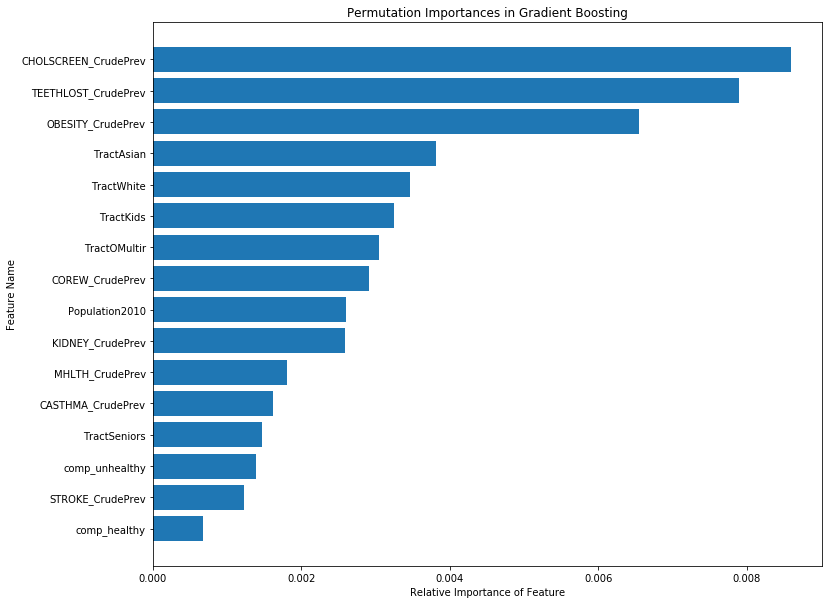

In [190]:
#GB
f_imp = permutation_importance(model,df_test.values,y_test.values)
fig,ax = plt.subplots(1,1,figsize=(12,10))
plot_feat_import(f_imp, df_test.columns, 20)

In [67]:
#RF
model = RandomForestClassifier()
model.fit(df_train,y_train)
y_predproba_rf = model.predict_proba(df_test)
fpr_rf,tpr_rf,thresholds=roc_curve(y_test.values,y_predproba_gb[:,1])

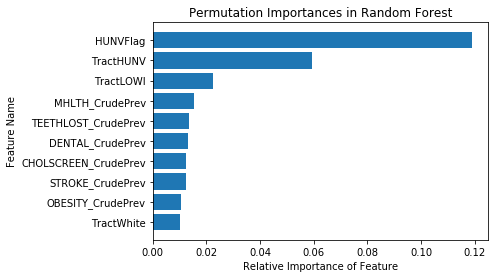

In [68]:
#RF
f_imp = permutation_importance(model,df_test.values,y_test.values)
plot_feat_import(f_imp, df_test.columns, 11)

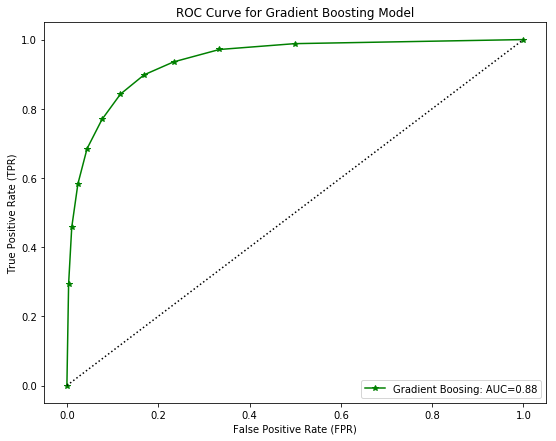

In [170]:
#ROC:
fig,ax = plt.subplots(1,1,figsize=(9,7))
ax.plot(fpr, tpr,label='Gradient Boosing: AUC=0.88',marker='*', color='green')
ax.plot([0,1],[0,1], 'k:')
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title("ROC Curve for Gradient Boosting Model")
#ax.plot(fpr_rf, tpr_rf,label='Random Forest',marker='*', color='blue',alpha=.5)
ax.legend(loc='lower right')

In [ ]:
#testing comp only

In [81]:
#df_comp=df_train[['HUNV''comp_healthy','comp_unhealthy','comp_grocery','comp_ff']]
df_comp=df_train[['HUNVFlag','TractHUNV','TractLOWI','OBESITY_CrudePrev','TEETHLOST_CrudePrev','TractOMultir','CHOLSCREEN_CrudePrev','TractWhite','MHLTH_CrudePrev','TractSeniors']]

In [82]:
#df_test_comp=df_test[['comp_healthy','comp_unhealthy','comp_grocery','comp_ff']]
df_test_comp=df_test[['HUNVFlag','TractHUNV','TractLOWI','OBESITY_CrudePrev','TEETHLOST_CrudePrev','TractOMultir','CHOLSCREEN_CrudePrev','TractWhite','MHLTH_CrudePrev','TractSeniors']]

In [83]:
#GB
model = GradientBoostingClassifier()
print("GRADIENT BOOSTING")
print()

print("TRAIN on GB")
print("ROC_AUC score: ", cross_val_score(model,df_comp,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_comp,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_comp,y_train,cv=5,scoring='f1').mean())

model.fit(df_comp,y_train)
y_pred = model.predict(df_test_comp)

print()
print("TEST on GB")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

GRADIENT BOOSTING

TRAIN on GB
ROC_AUC score:  0.9398684190033585
Accuracy score:  0.8650002090343373
f1 score:  0.8107303821361052

TEST on GB
ROC_AUC score:  0.8499565134309361
Accuracy score:  0.8636280095570668
f1 score:  0.8084667010841509
recall score:  0.8014329580348004
precision score:  0.815625


In [118]:
#gradient boosting grid search
gb_grid = {'n_estimators': [10,50,100],
                  'min_samples_leaf': [1, 7, 9, 13],
                  'max_depth': [2, 3, 4, 5],
                  'max_features': [2, 5, 10, 12,15,20],
                  'learning_rate': [0.01,.1,1]}
gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                             gb_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
gb_gridsearch.fit(df_train, y_train)

print( "best parameters:", gb_gridsearch.best_params_ )

best_gb_model = gb_gridsearch.best_estimator_

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 28.1min finished


best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 13, 'n_estimators': 100}


In [149]:
model = best_gb_model

In [150]:
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=13, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [151]:
model.fit(df_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=13, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [152]:
import pickle
with open('model.pkl', 'wb') as f:
        # Write the model to a file.
        pickle.dump(model, f)

In [121]:
#GB
print("GRADIENT BOOSTING")
print()

print("TRAIN on GB")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

model.fit(df_train,y_train)
y_pred = model.predict(df_test)

print()
print("TEST on GB")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

GRADIENT BOOSTING

TRAIN on GB
ROC_AUC score:  0.9565249971964267
Accuracy score:  0.888894047884488
f1 score:  0.8430242172854554

TEST on GB
ROC_AUC score:  0.8756138827092529
Accuracy score:  0.8884396250689212
f1 score:  0.84237860296027
recall score:  0.8300921187308086
precision score:  0.8550342646283605


In [124]:
#grid search for RF
param_grid={'n_estimators': [200,300,400],
            'max_depth': [3, None,1,2,5,7,10],
            'max_features': ['sqrt','log2', None]
           }

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             param_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
rf_gridsearch.fit(df_train,y_train)

best_estimator = rf_gridsearch.best_params_

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed: 28.7min finished


In [125]:
model = best_estimator

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}

In [126]:
#RF model
#new RF params
print("RANDOM FOREST GS")
print()

#train stats
print("TRAIN on RF")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

#predict and get test stats
model.fit(df_train,y_train)
y_pred = model.predict(df_test)

print()
print("TEST on RF")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

RANDOM FOREST GS

TRAIN on RF
ROC_AUC score:  0.956528802447713
Accuracy score:  0.8880209072343618
f1 score:  0.8429511076519292

TEST on RF
ROC_AUC score:  0.8727262747229878
Accuracy score:  0.8853151994118729
f1 score:  0.8383419689119171
recall score:  0.8280450358239508
precision score:  0.8488982161594963
